#For colab

# Define custom function

In [1]:
import numpy as np
import pandas as pd
import collections
import json
#from google.colab import drive
from matplotlib import pyplot as plt

#drive.mount('/gdrive')

In [23]:
#No biased에 대한 결과가 요정도..
def draw_pnl(input_pnl, index_list) :
    draw_data = pd.Series(input_pnl)
    draw_data.index = index_list
    plt.figure(figsize=(10,5))
    plt.plot(draw_data)
    plt.grid(b = True)
    return draw_data


"""
industry_list와 채워진 matrix set을 받으면 loading matrix 로 변환
loading matrix 출력 예시
#loading_m= industry_dic[industry_list[0]]

"""
def make_loading_matrix(industry_list, industry_fg) :
    industry_dic = {}
    for industry in industry_list :
        industry_dic.update({ industry :np.where(industry_fg.values == industry, 1, 0)})
        #print(industry)
    return industry_dic


"""
turn over 계산 function
input
    - portfolio_w : portfolio의 values(numpy type)
    - index_list : 사용하는 데이터의 index list
    
output 
- daliy turnover가 저장된 pd.series type 변수
"""

def make_turn_over_df(portfolio_w , index_list) :
    turn_over = np.zeros(len (portfolio_w))
    for i in range(len (portfolio_w)) :
        if i == len (portfolio_w) -2 :
            break;
        turn_over[i+1] = np.nansum(abs(portfolio_w[i+1] - portfolio_w[i]))

    turn_over_df = pd.Series(turn_over)
    turn_over_df.index = index_list
    return turn_over_df


"""
summary_pnl
 * 포트폴리오의 성과지표를 summary
input
    - portfolio_df : portfolio의 데이터프레임 타입(daily 별 포트폴리오 자산배분이 들어가있음)
    - price_s : 해당기간 주식들의 수익률 정보
    
output 
- summary table : sharp ratio/year pnl/turn over rate 평균등을 계산하고 plot함
"""

def summary_pnl(portfolio_df, turn_over_df, price_s) :
    
    daily_pnl = np.nansum(np.multiply( portfolio_df.values, price_s.values),1)
    #draw_pnl(np.cumsum(daily_pnl), price_s.index)
    cumsum_data = pd.Series(np.cumsum(daily_pnl))
    cumsum_data.index = price_s.index
    plt.figure(figsize=(10,5))
    plt.plot(cumsum_data)
    plt.grid(b = True)
    
    draw_data = pd.Series(daily_pnl)
    draw_data.index = price_s.index

    summary_table = pd.DataFrame(index=draw_data.resample('Y').mean().index , columns=['Sharp_ratio', 'Profit and Loss(%)', 'Turn_over_rate(%)'])
    summary_table['Sharp_ratio'] = draw_data.resample('Y').mean() *np.sqrt(250) / draw_data.resample('Y').std()
    summary_table['Profit and Loss(%)'] = draw_data.resample('Y').mean() *250
    summary_table['Turn_over_rate(%)'] = turn_over_df.resample('Y').mean() *100
    
    return summary_table



In [21]:
# mean_reversion 포트폴리오 생성 전략
def mean_reversion(input_data, industry_list, industry_dic) :
    #input_data = pr_rolling
    total_ammount = 1

    portfolio = np.zeros(input_data.shape)
    nn_price_s = input_data.values

    for industry in industry_list :
        print(industry)
        loading_m = industry_dic[industry]
        loading_return = np.where(loading_m == 1, nn_price_s, np.nan)
        #여기 0값 집어넣어서 난리남..

        for i in range(len(input_data.index)) :

            loading_return[i] -= np.nanmean(loading_return[i])
            loading_return[i] = np.where(np.isnan(loading_return[i]), 0, loading_return[i])

            portfolio[i] += loading_return[i] 


    portfolio = np.where(np.isnan(portfolio),0 , portfolio)
    portfolio = np.where(portfolio > 0 , -1, 1)

    abs_sum = np.sum(np.abs(portfolio), 1)
    weight = total_ammount/abs_sum 
    weight[total_ammount/abs_sum == np.inf] = 0
    d = np.diag(weight)
    portfolio_w = np.matmul(d, portfolio )


    #make portfolio df with init zero
    portfolio_df = input_data.copy()
    for col in portfolio_df.columns:
        portfolio_df[col].values[:] = 0

    portfolio_df.loc[:,:] = portfolio_w
    turn_over_df = make_turn_over_df(portfolio_w , input_data.index)
    
    
    portfolio_df = portfolio_df.shift(1)
    
    return portfolio_df,turn_over_df

In [30]:
def mean_reversion_nc(input_data):
    #input_data = pr_rolling
    total_ammount = 1

    #make portfolio df with init zero
    portfolio_df = input_data.copy()
    for col in portfolio_df.columns:
        portfolio_df[col].values[:] = 0

    #Calc  alpha
    for i,index in enumerate(input_data.index) :

        if i == len(input_data.index)-1 :
            break ;
        day_pr_arr = input_data.values[i]

        alpha =  (day_pr_arr - np.nanmean(day_pr_arr))
        alpha[~np.isnan(day_pr_arr)] = np.where( alpha[~np.isnan(day_pr_arr)] > 0, -1, 1)
        alpha -= np.nanmean(alpha)
        #alpha = -1 * (day_pr_arr -pr_rolling_ar[i] )
        weight_value = total_ammount/ np.sum(np.abs(day_pr_arr[~np.isnan(day_pr_arr)]))   

        alpha[~np.isnan(day_pr_arr)] = weight_value * alpha[~np.isnan(day_pr_arr)]
        portfolio_df.loc[input_data.index[i+1], :] = alpha
        
    turn_over_df = make_turn_over_df(portfolio_df.values , input_data.index)
    return portfolio_df, turn_over_df
    


In [4]:
with open('..//data//daily_price_v.json') as json_file:
    json_data = json.load(json_file)
price_s = pd.read_json(json_data)

with open('..//data//fg_sector_bfff_v.json') as json_file:
    json_data = json.load(json_file)
industry_fg = pd.read_json(json_data)


#Calc industry loading matrix



# get_indsutry_list

In [35]:
# get_industry_list 

with open('..//data//fg_sector.json') as json_file:
    industry_js = json.load(json_file)
industry_s = pd.read_json(industry_js)

#industry_s전처리 해줘야함..
industry_m = industry_s.copy()
for i in industry_m.columns :
    col = industry_m[i].values
    col = np.where(type(col) == float , 'NaN' , col)
    col = np.where(type(col) == 'nan' , 'NaN' , col)
    col = np.where(col == None , 'NaN'  , col)
    industry_m[i] = col


#한번더 후 처리
hey = industry_m.values
hey[hey == 'nan'] = 'NaN'
industry_m.loc[:,:] = hey

#후처리 한번더..
for i in industry_m.columns :
    col = industry_m[i].values
    col = np.where(type(col) == float , 'NaN' , col)
    col = np.where(type(col) == 'nan' , 'NaN' , col)
    col = np.where(col == None , 'NaN'  , col)
    industry_m[i] = col
    
    #industry_list check
    if i == industry_m.columns[0]:
        c = collections.Counter(industry_m[i])
    c += collections.Counter(industry_m[i])


industry_list = [*c.keys()]


In [54]:
price_s

,A005930,A000660,A035420,A005380,A207940,A012330,A068270,A051910,A055550,A005490,...,A900060,A900090,A900130,A900150,A900180,A950010,A950030,A950070,A950100,A950190
2009-01-01,-0.66,0.90,2.77,0.00,NaN,-0.32,-2.46,0.42,-0.83,0.80,...,NaN,NaN,NaN,NaN,NaN,-1.55,NaN,NaN,NaN,NaN
2009-01-02,4.21,7.16,-1.92,5.57,NaN,10.94,2.02,5.77,-0.67,3.42,...,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN
2009-01-05,1.28,0.56,-0.78,7.91,NaN,-2.00,1.49,4.39,9.15,1.65,...,NaN,NaN,NaN,NaN,NaN,4.21,NaN,NaN,NaN,NaN
2009-01-06,4.62,2.35,-3.56,2.22,NaN,-0.87,5.85,1.02,0.62,1.63,...,NaN,NaN,NaN,NaN,NaN,10.61,NaN,NaN,NaN,NaN
2009-01-07,5.22,1.22,6.97,8.48,NaN,2.94,5.99,2.27,1.70,5.91,...,NaN,NaN,NaN,NaN,NaN,12.33,NaN,NaN,NaN,NaN
2009-01-08,-3.05,6.02,-0.38,-4.01,NaN,-6.71,1.74,-3.83,-3.49,-4.19,...,NaN,NaN,NaN,NaN,NaN,-0.41,NaN,NaN,NaN,NaN
2009-01-09,-2.95,-7.44,0.00,-2.51,NaN,1.07,-1.71,-0.26,-4.40,-4.13,...,NaN,NaN,NaN,NaN,NaN,-3.67,NaN,NaN,NaN,NaN
2009-01-12,-0.71,-5.72,-3.46,-3.32,NaN,-1.52,-6.09,0.39,-2.63,-3.04,...,NaN,NaN,NaN,NaN,NaN,-1.27,NaN,NaN,NaN,NaN
2009-01-13,0.41,2.17,2.39,1.88,NaN,-3.08,3.24,1.03,2.20,-1.57,...,NaN,NaN,NaN,NaN,NaN,3.00,NaN,NaN,NaN,NaN
2009-01-14,-0.41,-4.81,2.33,4.35,NaN,6.19,0.00,1.40,5.79,0.53,...,NaN,NaN,NaN,NaN,NaN,-0.83,NaN,NaN,NaN,NaN


# get_industry dic

In [55]:
industry_list[0]

'FGSC.45'

In [53]:
industry_dic[industry_list[0]]

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [15]:
industry_dic = make_loading_matrix(industry_list, industry_fg)

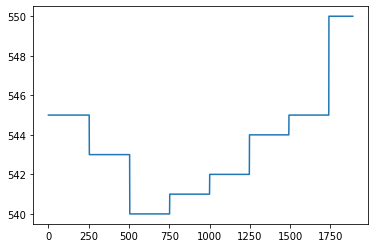

In [307]:
loading_m= industry_dic[industry_list[1]]
sector_1 = np.zeros(len(loading_m))
for i in range(len(loading_m)) :
    sector_1[i] = sum(loading_m[i])
plt.plot(sector_1)

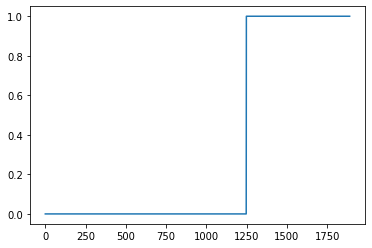

In [308]:
loading_m= industry_dic[industry_list[2]]
sector_1 = np.zeros(len(loading_m))
for i in range(len(loading_m)) :
    sector_1[i] = sum(loading_m[i])
plt.plot(sector_1)

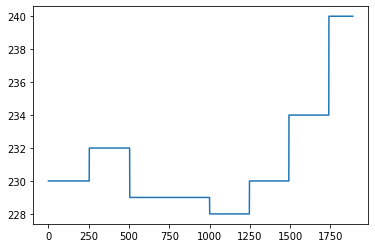

In [309]:
loading_m= industry_dic[industry_list[3]]
sector_1 = np.zeros(len(loading_m))
for i in range(len(loading_m)) :
    sector_1[i] = sum(loading_m[i])
plt.plot(sector_1)

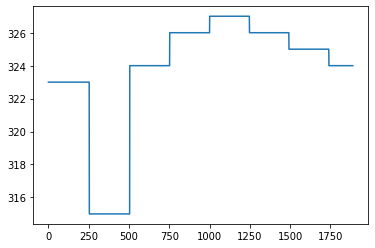

In [310]:
loading_m= industry_dic[industry_list[4]]
sector_1 = np.zeros(len(loading_m))
for i in range(len(loading_m)) :
    sector_1[i] = sum(loading_m[i])
plt.plot(sector_1)

# make portfolio 

In [ ]:
industry_dic

In [56]:
signal = price_s.rolling(5, min_periods=1).mean()
portfolio_df,turn_over_df = mean_reversion(signal, industry_list, industry_dic)

FGSC.45
FGSC.25
NaN


C:\Users\cobook\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice


FGSC.35
FGSC.15
FGSC.40
FGSC.30
FGSC.50
FGSC.20
FGSC.10
FGSC.55


,Sharp_ratio,Profit and Loss(%),Turn_over_rate(%)
2009-12-31,1.952500,5.121525,22.759087
2010-12-31,0.454815,0.927760,23.032617
2011-12-31,1.586978,4.855733,23.223668
2012-12-31,2.515367,5.439221,23.061258
2013-12-31,2.798358,4.764315,23.304145
2014-12-31,1.000591,1.621022,23.254226
2015-12-31,2.060435,5.462908,24.101652
2016-12-31,2.910449,6.455590,25.308454


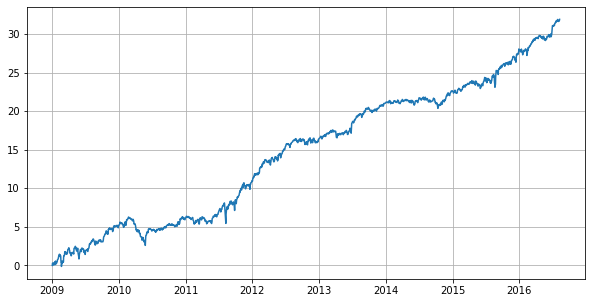

In [57]:
summary_pnl(portfolio_df, turn_over_df, price_s)

In [31]:
signal = price_s.rolling(5, min_periods=1).mean()
portfolio_df_nc,turn_over_df_nc = mean_reversion_nc(signal)

,Sharp_ratio,Profit and Loss(%),Turn_over_rate(%)
2009-12-31,1.325773,4.409403,38.686288
2010-12-31,-0.311945,-1.053154,47.472726
2011-12-31,1.298668,4.713885,44.562491
2012-12-31,0.408385,1.458432,47.459666
2013-12-31,1.908230,6.030775,57.298699
2014-12-31,-0.272001,-0.841012,54.256255
2015-12-31,-0.056719,-0.198834,43.507732
2016-12-31,0.843091,2.786745,51.332606


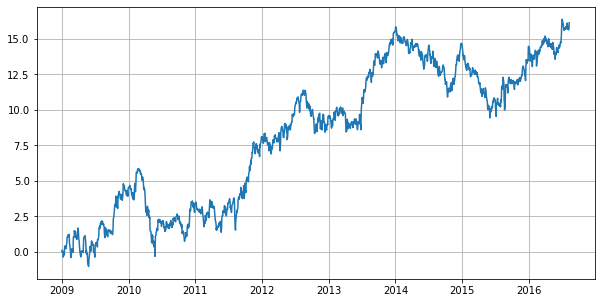

In [34]:
summary_pnl(portfolio_df_nc, turn_over_df_nc, price_s)